In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00709.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00372.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01850.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02017.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02363.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01

In [2]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [4]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")

In [5]:
def convert_format(box, iwidth=1024, iheight=1024):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [6]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((258, 258))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")


Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


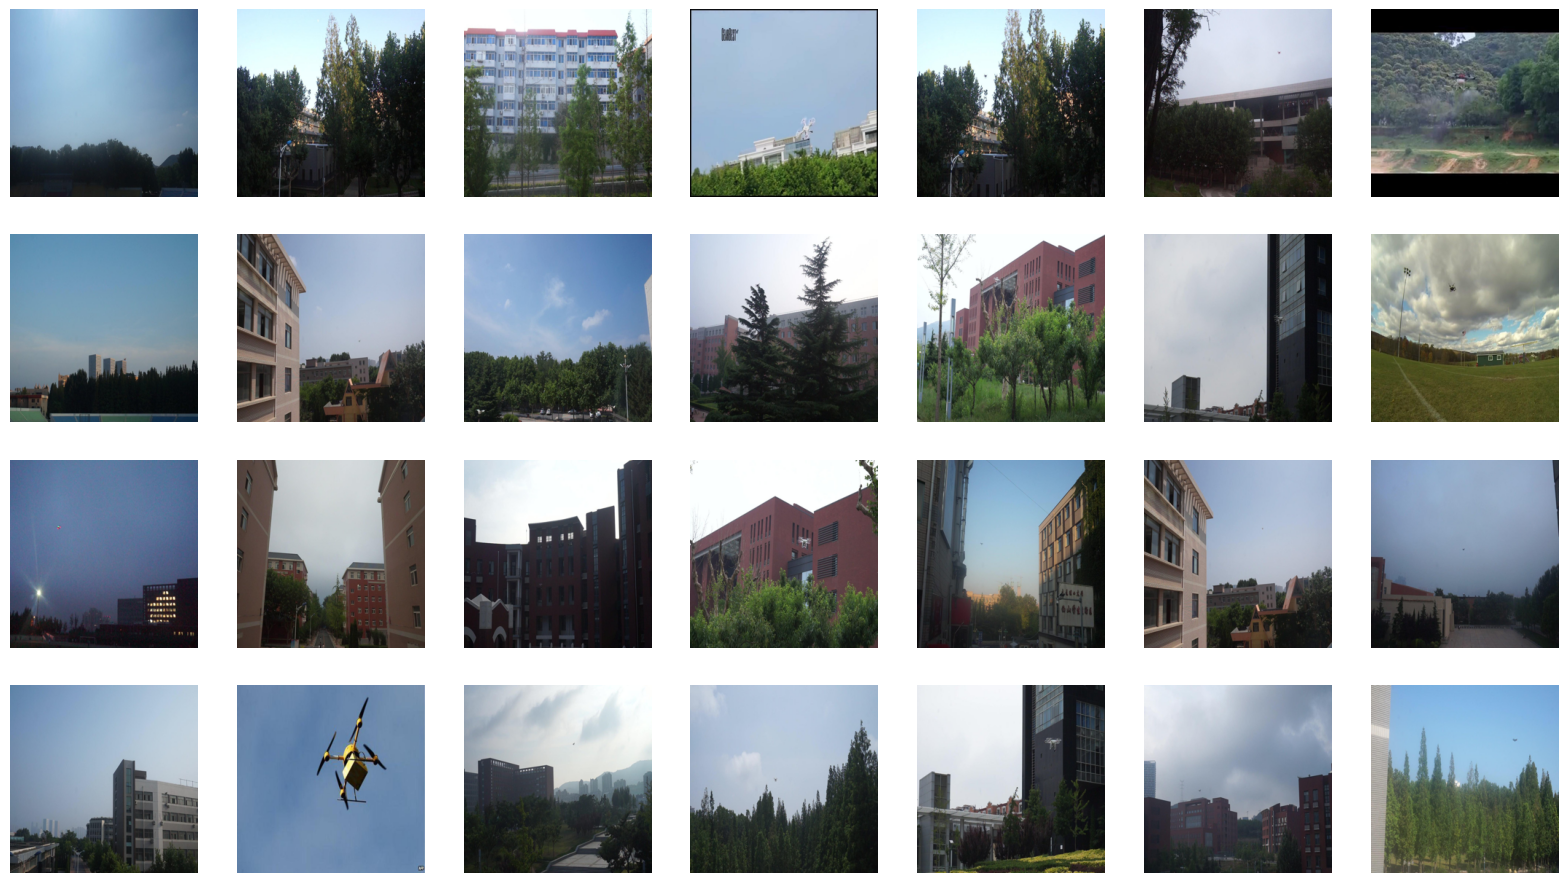

In [7]:
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [8]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

In [9]:
df

,boxes,img_path,labels,img_id
0,"[566, 703, 580, 714]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,04168
1,"[296, 360, 318, 383]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,02371
2,"[469, 381, 481, 390]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,04377
3,"[576, 594, 682, 716]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,00767
4,"[361, 352, 388, 381]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,02360
...,...,...,...,...
5192,"[489, 612, 505, 633]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,02956
5193,"[505, 615, 522, 629]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,04731
5194,"[157, 713, 190, 738]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,03358
5195,"[64, 513, 80, 521]",/kaggle/input/anti-uav-yolo-1024/train/images/...,drone,04801


In [10]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

In [11]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

In [12]:
df_removed_damaged = df.drop(df[(df.ymin > df.ymax) | (df.xmin > df.xmax)].index)
df_removed_damaged

,img_path,labels,img_id,xmin,ymin,xmax,ymax
0,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04168,566.0,703.0,580.0,714.0
1,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02371,296.0,360.0,318.0,383.0
2,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04377,469.0,381.0,481.0,390.0
3,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,00767,576.0,594.0,682.0,716.0
4,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02360,361.0,352.0,388.0,381.0
...,...,...,...,...,...,...,...
5192,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02956,489.0,612.0,505.0,633.0
5193,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04731,505.0,615.0,522.0,629.0
5194,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,03358,157.0,713.0,190.0,738.0
5195,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04801,64.0,513.0,80.0,521.0


In [13]:
train_ds=df_removed_damaged[:4000]
val_ds=df_removed_damaged[4000:]
train_ds

,img_path,labels,img_id,xmin,ymin,xmax,ymax
0,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04168,566.0,703.0,580.0,714.0
1,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02371,296.0,360.0,318.0,383.0
2,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,04377,469.0,381.0,481.0,390.0
3,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,00767,576.0,594.0,682.0,716.0
4,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02360,361.0,352.0,388.0,381.0
...,...,...,...,...,...,...,...
3995,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02303,607.0,420.0,627.0,436.0
3996,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02648,477.0,747.0,500.0,775.0
3997,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,03674,322.0,659.0,340.0,678.0
3998,/kaggle/input/anti-uav-yolo-1024/train/images/...,1,02833,192.0,858.0,242.0,900.0


In [14]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (1024, 1024))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        if len(boxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([index]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros(0, dtype=torch.int64)
            }
        else:
            # Normalize bounding box coordinates
            boxes[:, [0, 2]] /= cols  # Normalize x coordinates
            boxes[:, [1, 3]] /= rows  # Normalize y coordinates

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            label = records['labels'].values
            labels = torch.as_tensor(label, dtype=torch.int64)

            # Suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([index]),
                'area': area,
                'iscrowd': iscrowd
            }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # Only stack the boxes if there are non-empty bounding boxes
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [15]:
def get_transform_train():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TrainDataset(train_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())
valid_dataset = TrainDataset(val_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_valid())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
images,targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
classes= {1:'drone'}

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(6,4, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy() * 255
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [19]:
!pip install pycocotools
! pip install -U ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.1 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=046d6be0d165aa19044cbf220f95c5e722f850117940d7b22a66064929a154cb
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [21]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
num_classes=2

in_channels=det_utils.retrieve_out_channels(model.backbone,(1024,1024))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 90.3MB/s] 


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [22]:
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
parameters=[params for params in model.parameters() if params.requires_grad]

learning_rate=3e-5
optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

In [23]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [24]:
"""Model has been trained and its weights are stored in pothole-detection-learned-weights,
if you want to train it yourself uncomment the below code, it takes around 50 minutes."""

epochs=10
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_data_loader.dataset)
val_len=len(valid_data_loader.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    for imgs,targets in train_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    with torch.no_grad():
        for imgs,targets in valid_data_loader:
            imgs=[img.to(device) for img in imgs]
            #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
            
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
        
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

/tmp/ipykernel_34/3429590343.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
/tmp/ipykernel_34/3429590343.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Updating Best Model weights

1/10
Training Loss: 5.061176141051973
Validation_loss: 20.970978032740977

**************************************************
Updating Best Model weights

2/10
Training Loss: 4.954385059924673
Validation_loss: 20.394972732440994

**************************************************
Updating Best Model weights

3/10
Training Loss: 4.876145695892518
Validation_loss: 20.071355457802575

**************************************************
Updating Best Model weights

4/10
Training Loss: 4.80617727692456
Validation_loss: 19.824941822121815

**************************************************
Updating Best Model weights

5/10
Training Loss: 4.74374055564118
Validation_loss: 19.633036828155493

**************************************************
Updating Best Model weights

6/10
Training Loss: 4.6798377488650855
Validation_loss: 19.436077433351468

**************************************************
Updating Best Model weights

7/10
Training Loss: 4.626483165844276
Vali

NameError: name 'model_weights_file' is not defined

In [25]:
loss_history

{'training_loss': [5.061176141051973,
  4.954385059924673,
  4.876145695892518,
  4.80617727692456,
  4.74374055564118,
  4.6798377488650855,
  4.626483165844276,
  4.568193773438353,
  4.512271549123968,
  4.453654532470017],
 'validation_loss': [20.970978032740977,
  20.394972732440994,
  20.071355457802575,
  19.824941822121815,
  19.633036828155493,
  19.436077433351468,
  19.27142058004994,
  19.11354630004341,
  18.953537992205877,
  18.784164150905664]}

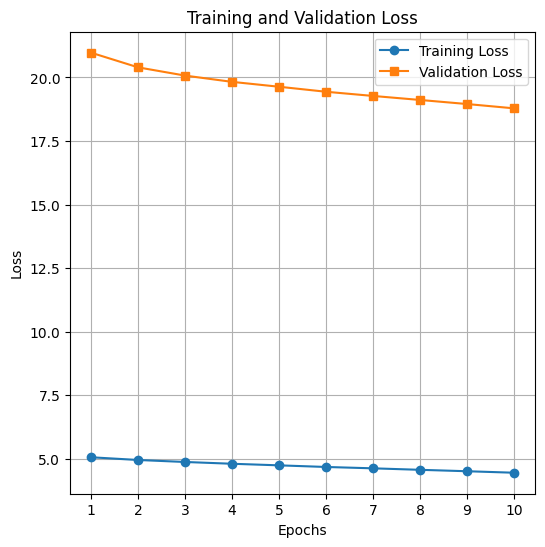

In [26]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(6, 6))
plt.plot(range(1, epochs+1),loss_history["training_loss"], label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), loss_history["validation_loss"], label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import json

# Save loss_history dictionary to a JSON file
with open('loss_history.json', 'w') as json_file:
    json.dump(loss_history, json_file)

In [28]:
torch.save(model.state_dict(), 'ssdmodeldict.pth')

In [29]:
torch.save(model, 'ssdentire_model.pth')